In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torchvision import transforms, datasets

In [24]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')

else:
    DEVICE = torch.device('cpu')

print(DEVICE)

cuda:0


In [25]:
BATCH_SIZE = 32

train_dataset = datasets.MNIST(
    root = '../data/MNIST',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_dataset = datasets.MNIST(
    root = '../data/MNIST',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [26]:
images, labels = next(iter(train_loader)) #이터레이터 성격 띄는지 확인.

print('images: ', images.size(), 'type: ', images.type())
print('labels: ', labels.size(), 'type', labels.type())

images:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
labels:  torch.Size([32]) type torch.LongTensor


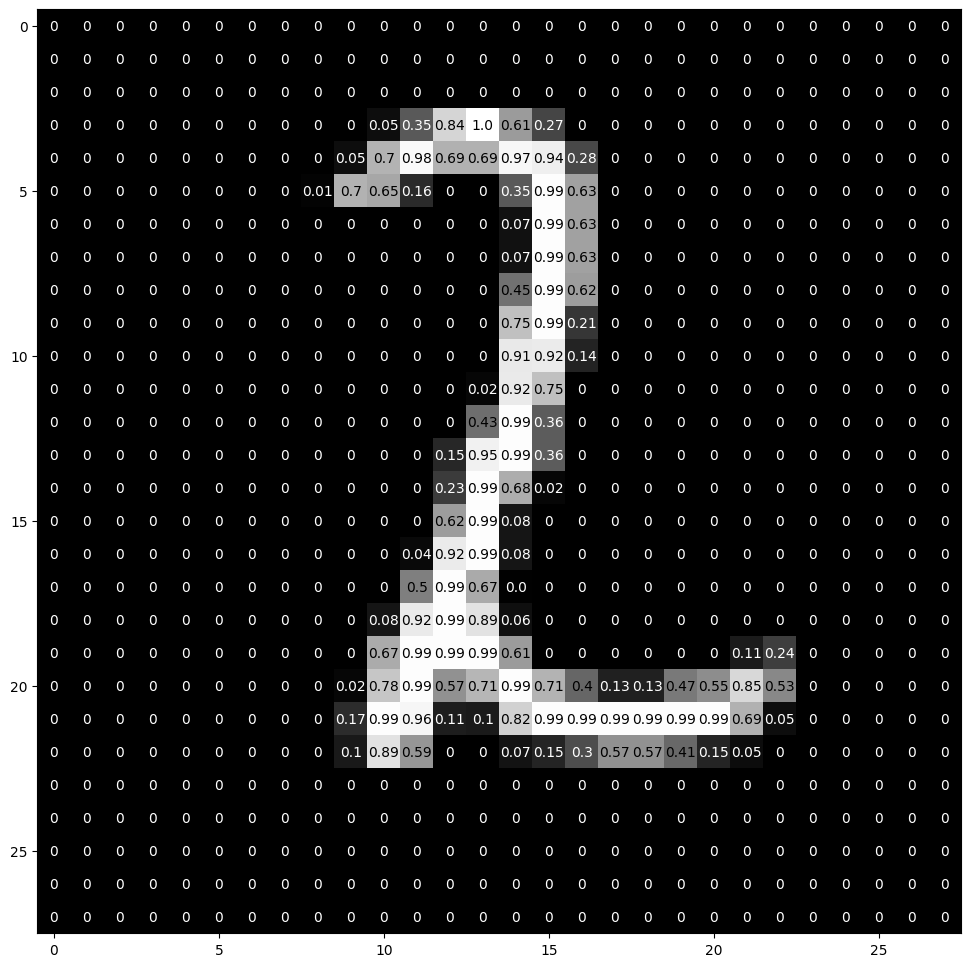

In [27]:
idx = 7

img = np.squeeze(images[idx].numpy())

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = 'gray')

width, height = img.shape

thresh = img.max() / 2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy = (y,x),
                        horizontalalignment = 'center',
                        verticalalignment = 'center',
                        color = 'white' if img[x][y] < thresh else 'black')
    ## 저번꺼 복습 ##

Text(0.5, 1.0, '3')

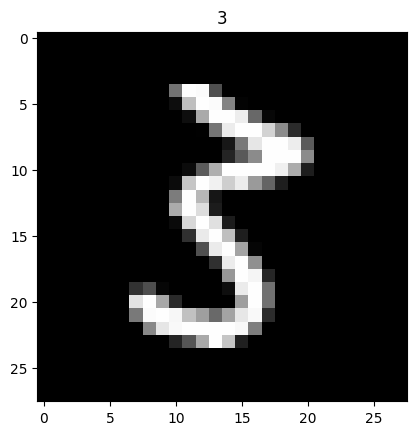

In [28]:
idx = 2
plt.imshow(np.squeeze(images[idx]), cmap = 'gray')
plt.title(str(labels[idx].item()))

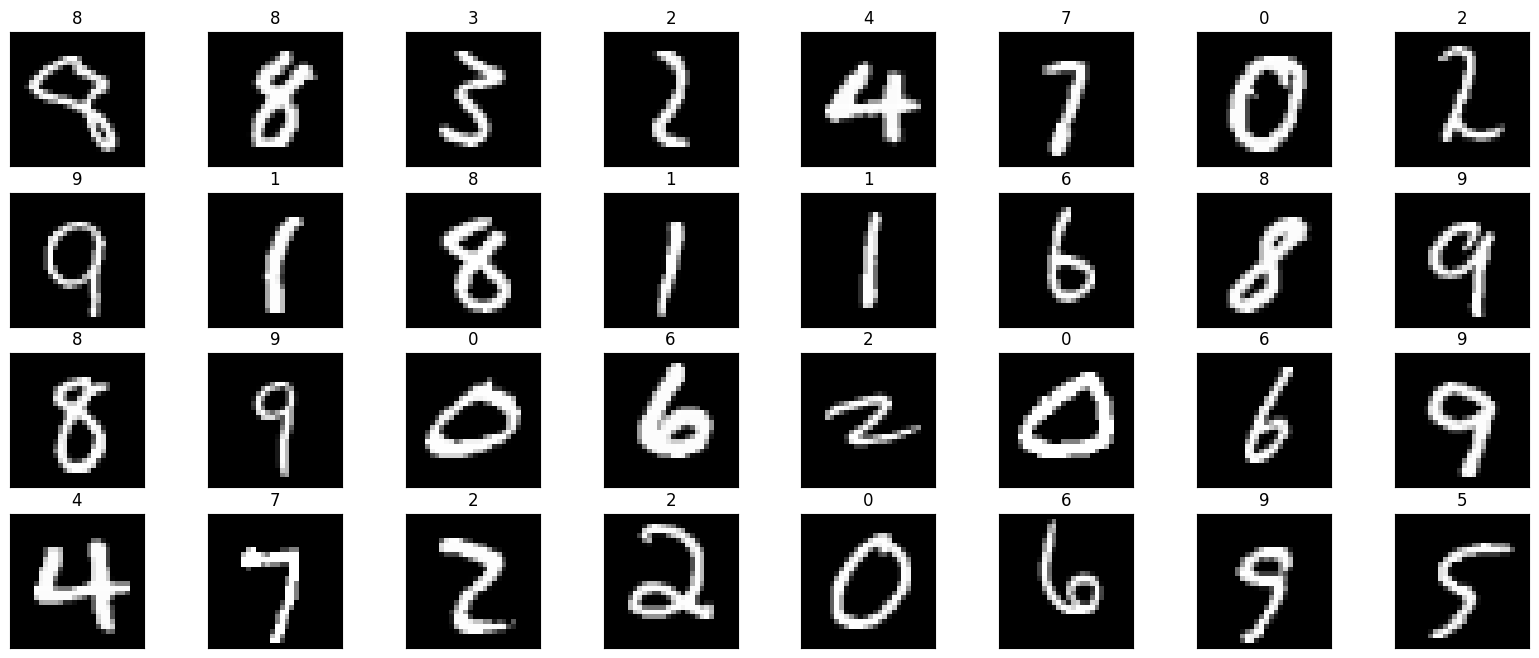

In [29]:
fig = plt.figure(figsize = (20, 8))

for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, int(BATCH_SIZE / 4), idx + 1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
    ax.set_title(str(labels[idx].item()))

In [30]:
def imshow(img):
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

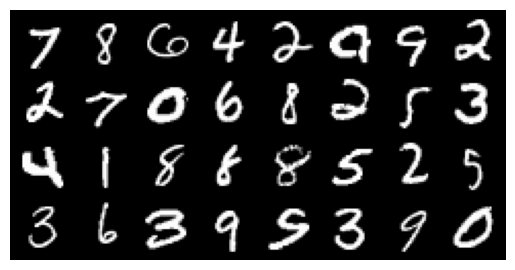

In [31]:
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

In [32]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x): #인제 위에 꺼 다 연결.
        x = x.view(-1, 28 * 28) # 100*28*28을 -1 * 784로 꽃아 넣기.
        x = self.fc1(x)
        x = F.relu(x) #relu가 y축 0 밑으로는 안내려감.(음수 취급 x)
        
        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) #모든 확률 다 더하면 1되도록 하는 softmax

        return x   

In [33]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)

model = MLP().to(DEVICE)
model.apply(weight_init)


MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #학습률 조정
loss_fn = nn.CrossEntropyLoss() #손실함수 지정.

In [41]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (image, label) in enumerate(train_loader): #enumerate로 열거
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() # 반복문마다 초기화
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward() #역전파 알고리즘(backward())
        optimizer.step()
        train_loss += loss_fn(output, label).item() # train_loss 추가. ##
        prediction = output.max(1, keepdim = True)[1] #
        correct += prediction.eq(label.view_as(prediction)).sum().item() #

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct / len(train_loader.dataset) ####

    return train_loss, train_accuracy

In [42]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = 100 * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

In [43]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader) 

    print("[EPOCH: {}], \tTrain_Loss: {:.4f}, \tTrain_Accuracy: {:.2f} %, \tTest_Loss: {:.4f}, \tTest_Accuracy: {:.2f} %".format(
        epoch, train_loss, train_accuracy, test_loss, test_accuracy
    ))

[EPOCH: 1], 	Train_Loss: 0.0090, 	Train_Accuracy: 92.02 %, 	Test_Loss: 0.0073, 	Test_Accuracy: 93.39 %
[EPOCH: 2], 	Train_Loss: 0.0060, 	Train_Accuracy: 95.03 %, 	Test_Loss: 0.0051, 	Test_Accuracy: 95.68 %
[EPOCH: 3], 	Train_Loss: 0.0053, 	Train_Accuracy: 95.73 %, 	Test_Loss: 0.0054, 	Test_Accuracy: 95.61 %
[EPOCH: 4], 	Train_Loss: 0.0047, 	Train_Accuracy: 96.18 %, 	Test_Loss: 0.0058, 	Test_Accuracy: 95.16 %
[EPOCH: 5], 	Train_Loss: 0.0046, 	Train_Accuracy: 96.44 %, 	Test_Loss: 0.0058, 	Test_Accuracy: 95.99 %
[EPOCH: 6], 	Train_Loss: 0.0040, 	Train_Accuracy: 96.83 %, 	Test_Loss: 0.0046, 	Test_Accuracy: 96.48 %
[EPOCH: 7], 	Train_Loss: 0.0038, 	Train_Accuracy: 97.06 %, 	Test_Loss: 0.0057, 	Test_Accuracy: 96.20 %
[EPOCH: 8], 	Train_Loss: 0.0036, 	Train_Accuracy: 97.11 %, 	Test_Loss: 0.0072, 	Test_Accuracy: 95.34 %
[EPOCH: 9], 	Train_Loss: 0.0038, 	Train_Accuracy: 97.31 %, 	Test_Loss: 0.0069, 	Test_Accuracy: 96.10 %
[EPOCH: 10], 	Train_Loss: 0.0035, 	Train_Accuracy: 97.45 %, 	Test_Loss: 0

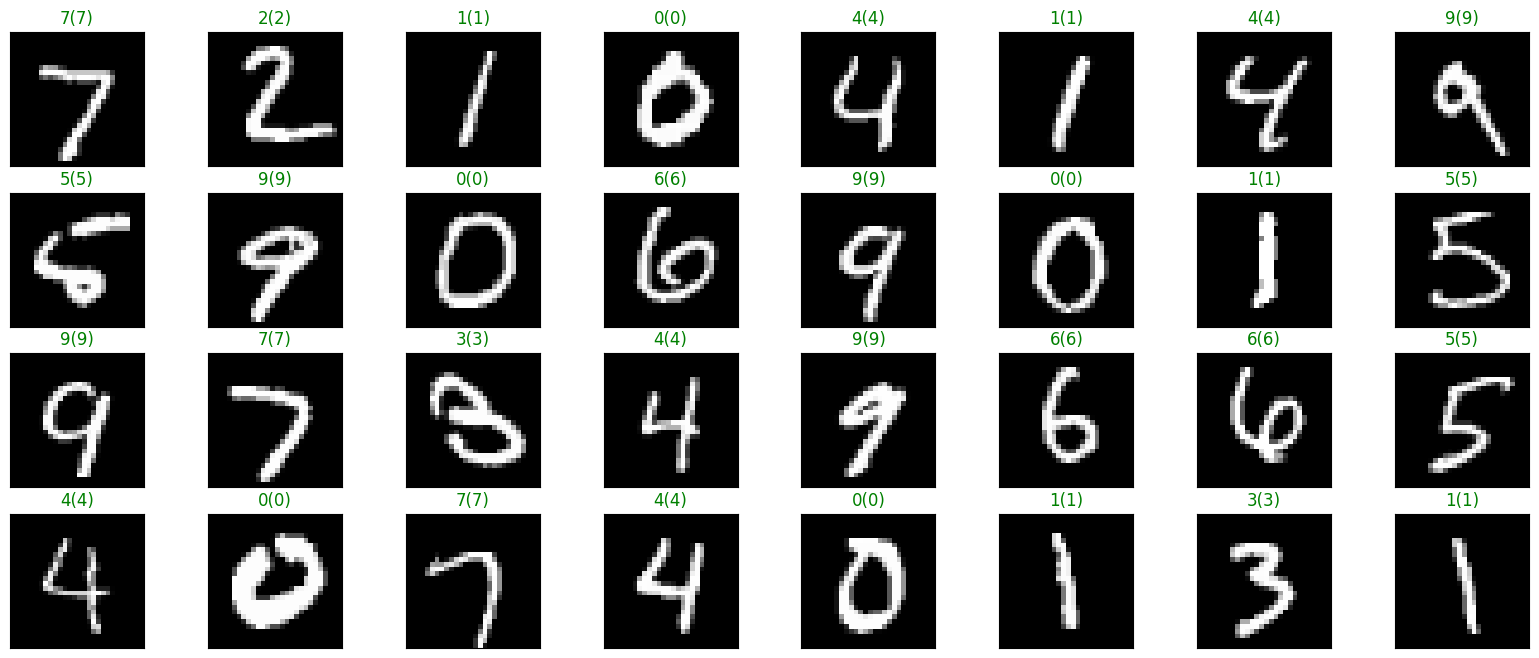

In [44]:
images, labels = next(iter(test_loader))
images = images.to(DEVICE)
labels = labels.to(DEVICE)

output = model(images)
_, preds = torch.max(output, 1) ##전체 열을 기준으로 최댓값 뽑아라.
images = images.cpu().numpy()

fig = plt.figure(figsize=(20,8))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, int(BATCH_SIZE/4), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{}({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))